### **Non-Linear Bias Measurement Notebook with FastPT:**

**Last Run: 1/13/2020**

For any questions, suggestions, or issues with the notebook please email Sam Goldstein at samgolds@sas.upenn.edu

**Summary:**

Computes the galaxy-galaxy, galaxy-matter, and matter-matter power spectra for galaxy and dark matter particle snapshot catalogs. Fits and compares models

**Outline:**

#### **Import Files and Setup Configuration:**

This cell imports the necessary libraries for the notebook, loads a catalog, and initializes cosmology parameters from the loaded catalog which will be used extensively throughout the notebook. Computes $\sigma_\chi$ defined as $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$. OuterRim simulation data is loaded using the Genericio Library.

In [1]:
import sys

fastpt_path = r"/global/u2/s/samgolds/FAST-PT/"
genericio_path = (r"/global/u2/s/samgolds/DC2-analysis/contributed/"
                  "nonlinear_bias/genericio/python/")

sys.path.append(fastpt_path)
sys.path.append(genericio_path)

from FASTPT import *
import genericio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys
import GCRCatalogs

from scipy.constants import speed_of_light
from matplotlib.ticker import NullFormatter

sns.set(style='ticks')

%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'

# Global constants to be used in various computations
cat_str = "baseDC2_snapshot_z1.01_v0.1"
dark_matter_file = ("/global/projecta/projectdirs/lsst/groups/CS/"
                    "cosmoDC2/Outer_snapshots/z1.01/m000.mpicosmo.247")

def get_catalog_cosmology(cat_str):
    """
    Helper function to return catalog cosmology object and redshift
    """
    
    cat = GCRCatalogs.load_catalog(cat_str)
    
    return cat.cosmology, cat.redshift

pi = np.pi
COSMO, Z_RED_SHIFT = get_catalog_cosmology(cat_str)

COSMO_CCL = pyccl.Cosmology(h=COSMO.h, sigma8=COSMO.sigma8,
                            Omega_g=COSMO.Ogamma0, Omega_k=COSMO.Ok0,
                            Omega_c=COSMO.Odm0, Omega_b=COSMO.Ob0,
                            n_s=COSMO.n_s, Neff=COSMO.Neff)

# Compute sigma chi
H0 = 71.0
SIGMA_Z = 0.05*(1+Z_RED_SHIFT)
SCALE_FACTOR = 1/(1+Z_RED_SHIFT)
H_Z = pyccl.background.h_over_h0(COSMO_CCL, SCALE_FACTOR)*H0

SIGMA_CHI = (speed_of_light/10**3)/H_Z*SIGMA_Z

# Select which direction is radial (X, Y, or Z)
RADIAL_DIR = "Z"

assert(str.lower(RADIAL_DIR)=="x" or 
       str.lower(RADIAL_DIR)=="y" or
       str.lower(RADIAL_DIR)=="z"), "Invalid Radial Direction Selection."

#### **Load and Mask Galaxy and Dark Mattter Particle Position Data:**

Defines functions to load galaxy and dark matter particle data and apply a Gaussian kernel in according to the radially defined position coordinate, $q_r$, to model radial distributions in a tomogrpahic redshift bin defined as $e^{-\frac{(q_r-\bar{q_r})^2}{2\sigma_\chi^2}}$. Coodinates are defined as $q_1, q_2, q_r$ corresponding to either $X$, $Y$ or $Z$ depending on the choice of radial direction as outlined below:
* X Radial Direction: $(q_1, q_2, q_r) = (Y, Z, X)$
* Y Radial Direction: $(q_1, q_2, q_r) = (Z, X, Y)$
* Z Radial Direction: $(q_1, q_2, q_r) = (X, Y, Z)$


Functions are defined to return minimal sufficient data to prevent memory errors when reading entire catalog.

In [2]:
def mask_positions(q1_data, q2_data, qr_data):
    """
    A helper function which applies a gaussian mask to select galaxies based on 
    their radial position data. q1 and q2 refer to perpendicular positions (e.g. if 
    Z is radial then q1 = X and q2 = Y)

    Parameters:
    q1_data (float array): np array containing first perpendicular positions of galaxies in Mpc
    q2_data (float array): np array containing second perpendicular positions of galaxies in Mpc
    radial_data (float array): np array containing radial positions of galaxies in Mpc

    Returns:
    q1_masked (float array): np array containing x positions of masked galaxies
    in Mpc
    q2_masked (float array): np array containing y positions of masked galaxies 
    in Mpc
    """
    
    # Apply Gaussian kernel with mean z_bar and std_dev = sigma_chi
    qr_bar = np.mean(qr_data)
    
    cutoffs = np.random.uniform(0, 1, len(qr_data))
    
    mask_ind = np.where(cutoffs < 
                        np.exp(-(qr_data-qr_bar)**2/(2*SIGMA_CHI**2)))[0]

    q1_masked = q1_data[mask_ind]
    q2_masked = q2_data[mask_ind]

    return q1_masked, q2_masked

def load_dark_matter_positions(file_str, x_bounds, y_bounds, z_bounds):
    """
    Loads and applies preliminary filters to dark matter position data in Mpc
    from a specified catalog and then applies a Gaussian kernel

    Parameters:
    file_str (string): location of file to load dark matter particles from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    # Load data from catalog using genericio
    x_data = np.array(genericio.gio_read(file_str, "x")[0])
    y_data = np.array(genericio.gio_read(file_str, "y")[0])
    z_data = np.array(genericio.gio_read(file_str, "z")[0])
    
    # Convert from Mpc/h to Mpc
    x_data *= 100/H0
    y_data *= 100/H0
    z_data *= 100/H0
    
    # Select particles within bounds
    bound_ind = np.where((x_data > min_x) & (x_data < max_x) &
                         (y_data > min_y) & (y_data < max_y) &
                         (z_data > min_z) & (z_data < max_z))
    
    x_data = x_data[bound_ind]
    y_data= y_data[bound_ind]
    z_data = z_data[bound_ind]
               
    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask
    q2_masked = None  # Second perpendicular coordinate post mask
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(x_data, z_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, mag_cut):
    """
    Loads and applies preliminary filters to galaxy position data in Mpc
    from a specified catalog

    Parameters:
    cat (GCRCatalog): catalog to load data from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)
    mag_cut (float): apparent magnitude cut value (max value)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Load catalog
    cat = GCRCatalogs.load_catalog(cat_str)
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    print("Loading Galaxy Catalog Data: ")

    cat_vals = cat.get_quantities(["position_x", "position_y", "position_z",
                                   "Mag_true_r_lsst_z0"],
                                  filters=["position_x < {}".format(max_x),
                                           "position_x > {}".format(min_x),
                                           "position_y < {}".format(max_y),
                                           "position_y > {}".format(min_y),
                                           "position_z > {}".format(min_z),
                                           "position_z < {}".format(max_z)])
    
    print("Applying Apparent Magnitude Cut: ")

    # Convert absolute to apparent magnitude
    r_Mag = cat_vals["Mag_true_r_lsst_z0"]
    r_mag = r_Mag+cat.cosmology.distmod(Z_RED_SHIFT).value

    # Remove all entries below mag_cut
    filtered_indices = np.where(r_mag < mag_cut)[0]

    x_data = cat_vals["position_x"][filtered_indices]
    y_data = cat_vals["position_y"][filtered_indices]
    z_data = cat_vals["position_z"][filtered_indices]

    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask (e.g. x, y, or z)
    q2_masked = None  # Second perpendicular coordinate post mask (e.g. x, y, or z)
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(z_data, x_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

### **Loading Data:**


In [3]:
# Apply above defined functions to load dark matter particle and galaxy data

# Define boundaries/data constraints
mag_cut = 24.5  # Consider only galaxies with apparent magnitude above 24.5

x_bounds = (0, 4225) # Entire x range
y_bounds = (0, 4225) # Entire y range
z_bounds = (1112, 3112) # Galaxies outside this window will likely be cut by Gaussian kernel

# Load dark matter particle data from first file
print("Loading Dark Matter Particle Data")
q1_data_dm, q2_data_dm = load_dark_matter_positions(dark_matter_file+"#0", 
                                                      x_bounds, y_bounds, z_bounds)

# Load dark matter particle data from remaining files
for i in range(1, 256):
    progress_bar(i, 256)
    q1_data_n, q2_data_n = load_dark_matter_positions(dark_matter_file+"#"+str(i), 
                                                        x_bounds, y_bounds, z_bounds)
    
    q1_data_dm = np.append(q1_data_dm, q1_data_n)
    q2_data_dm = np.append(q2_data_dm, q2_data_n)
    
    progress_bar(i, 256)

sys.stdout.flush()  # Clears output to prevent writing over progress bar
print("")

# Load galaxy data
q1_data_g, q2_data_g = load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, 
                                             mag_cut)

# Compute N_BAR_DM and N_BAR_G (average number of particles/galaxies per Mpc^2)
q1_width_dm = np.max(q1_data_dm)-np.min(q1_data_dm)
q2_width_dm = np.max(q2_data_dm)-np.min(q2_data_dm)
N_BAR_DM = len(q1_data_dm)/(q1_width_dm*q2_width_dm)

q1_width_g = np.max(q1_data_g)-np.min(q1_data_g)
q2_width_g = np.max(q2_data_g)-np.min(q2_data_g)
N_BAR_G = len(q1_data_g)/(q1_width_g*q2_width_g)

Loading Dark Matter Particle Data
Progress: [------------------->] 100%
Loading Galaxy Catalog Data: 
Applying Apparent Magnitude Cut: 


#### **Get Power-Spectra From Data:**

Code cell below defines a method for calculating the 2D power spectrum for x and y data with a specified resolution size *N* by computing the over-density field, 2-point correlation function, and then applying a 2D FFT. Additionally, a function is defined to compute the cross power spectrum using a similar procedure. Finally, a method is defined for averaging power spectrum values in bins of wavenumbers.

In [4]:
def calculate_auto_pow_spec(q1_data, q2_data,  N, bad_ind):
    """ 
    Calculates the 2D auto power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation
    bad_ind (np int array): Array containing the indicies of any erroneous power
    spectra data points

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """

    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)

    # Perform fourier transform
    delta_k = np.fft.fft2(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))/(N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to specified key for removal at end of computation
    bad_ind_key = 888888
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
        
    p_k = pow_spec.flatten()
    
    # Get frequency values
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+kq2_mat**2)
    
    k_vals = k_mat.flatten()
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values    
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]


def get_over_density(q1_data, q2_data, N):
    """
    Computes the over-density field from data with N*N grid. Used in cross power 
    spectrum computation

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    delta (np float array): 2D NxN array with the over-density field computed from
    q1_data and q2_data

    """
    
    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)
    
    return delta


def calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm, q2_data_dm,  N, bad_ind):
    """ 
    Calculates the 2D cross power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data_g (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data_g (np float array): Array containing q2 positions of galaxies in Mpc
    q1_data_dm (np float array): Array containing q1 positions of dark matter 
    particles in Mpc
    q2_data_dm (np float array): Array containing q2 positions of dark matter 
    particles in Mpc
    N (int): Integer representing the grid size for the power spec calculation
    bad_ind (np int array): Array containing the indicies of any erroneous power
    spectra data points

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """
    
    # Compute over-density
    delta_g = get_over_density(q1_data_g, q2_data_g, N)
    delta_dm = get_over_density(q1_data_dm, q2_data_dm, N)

    # Perform fourier transform
    delta_k_g = np.fft.fft2(delta_g)
    delta_k_dm = np.fft.fft2(delta_dm)

    # Calculate power spectrum
    pow_spec = np.real(delta_k_dm*np.conj(delta_k_g))
    
    # Normalize power spectrum 
    q1_width = np.ceil(np.max(q1_data_g))-np.floor(np.min(q1_data_g))
    q2_width = np.ceil(np.max(q2_data_g))-np.floor(np.min(q2_data_g))
    
    pow_spec /= (N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to specified key for removal at end of computation
    bad_ind_key = 888888 
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
    
    p_k = pow_spec.flatten()
    
    # Get frequency values
    delta_q1 = q1_width/N
    delta_q2 = q2_width/N
    
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+(kq2_mat)**2)
    
    k_vals = k_mat.flatten()
    
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]
    

def average_pow_spec(k_vals, p_vals, n_bins):
    """
    Averages power spectrum into n_bins based on k
    
    Parameters:
    k_vals (np float array): array containing the unaverged wave numbers in 
    Mpc^-1
    p_k (np float array): array containing the unaveraged power spectrum values in
    Mpc^2
    n_bins (int): integer representing the number of bins to average values into

    Returns:
    averaged_k (np float array): array containing the averaged wave numbers in
    Mpc^-1
    averaged_p (np float array): array containing the averged power spectrum values in
    Mpc^2
    n_modes (np int array): array containing the number of Fourier modes in each bin of 
    averaged_k/averaged_p
    """

    averaged_p, averaged_k, binnumbers = scipy.stats.binned_statistic(k_vals, p_vals, 'mean', bins=n_bins)
    
    # Compute average wave number of each bin
    averaged_k = averaged_k+(averaged_k[1]-averaged_k[0])/2
    
    # Calculate n_modes from bin number
    n_modes = np.bincount(binnumbers)[1:]
    
    return averaged_k[:-1], averaged_p, n_modes

#### **Compute Galaxy, Dark Matter Particle Auto and Cross Power Spectra:**

Uses the above defined functions to compute the relevant power spectrum on an array of size $N$ and averages the data into $N_{avg}$ points according to wavenumber.

In [5]:
# Array of dimension, N, to compute the power spectrum over
N = 10000
N_avg = 1024

# Select indices to exclude (accounting for simulation bin errors)
bad_ind = np.array([64, 128, 192, 256])
bad_ind = np.append(bad_ind, np.flip(N-bad_ind))

print("Calculating Galaxy Power Spectrum")
k_g, p_gg, n_modes_g = average_pow_spec(*calculate_auto_pow_spec(q1_data_g, q2_data_g, N, bad_ind), N_avg)


print("Calculating Dark Matter Power Spectrum ")
k_dm, p_dm, n_modes_dm = average_pow_spec(*calculate_auto_pow_spec(q1_data_dm, q2_data_dm, N, bad_ind), N_avg)

print("Calculating Cross Power Spectrum")
k_cross, p_gm, n_modes_cross = average_pow_spec(*calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm,
                                                                               q2_data_dm,  N, bad_ind), N_avg)

# Ensure all power spectrum values have the same wave number and each bin has same number of modes
assert(all((k_g == k_dm) & (k_g == k_cross)))
k = k_g

assert(all((n_modes_g == n_modes_dm) & (n_modes_g==n_modes_cross)))
n_modes = n_modes_g

k = k_g
n_modes = n_modes_g

Calculating Galaxy Power Spectrum
Calculating Dark Matter Power Spectrum 
Calculating Cross Power Spectrum


#### **Define MCMC Class for MLE:**

Defines an MCMC class to obtain parameter estimates for a specified likelihood function using Metropolis Hastings

In [6]:
class MCMC(object):
    """
    FOR FUTURE USE (DOCUMENT LATER)
    """
    def __init__(self, log_likelihood, data, theta, step_size, names=None, seed=314159):
        self.log_likelihood = log_likelihood
        self.data = data
        self.theta = np.array(theta)
        self.nparams = len(theta)
        self.step_size = np.array(step_size)
        self.rng = np.random.RandomState(seed)
        self.naccept = 0
        self.current_loglike = log_likelihood(self.data, self.theta)
        self.samples = []
        if names is None:
            names = ["Paramter {:d}".format(k+1) for k in range(self.nparams)]
        self.names = names            

    def step(self, save=True):

        theta_new = self.theta+self.step_size*np.random.normal(size = len(self.theta))
        
        pnew = self.log_likelihood(self.data, theta_new)

        ratio = np.exp(pnew-self.current_loglike)

        if ratio >= 1:
            take_step = 1
        else:
            stepran = np.log(np.random.uniform())
            if stepran < pnew-self.current_loglike:
                take_step = 1
            else:
                take_step = 0
                
        if take_step:
            self.current_loglike = pnew
            self.theta = theta_new
        
        if save:
            self.samples.append(self.theta)
            if take_step:
                self.naccept += 1
    
    def burn(self, nburn):
        
        for i in range(nburn):
            self.step(save=False)

    def run(self, nsteps):
        
        for i in range(nsteps):
            self.step()

    def accept_fraction(self):

        if len(self.samples) > 0:
            return float(self.naccept) / len(self.samples)
        else:
            return 0.
        
    def clear(self, step_size=None, theta=None):

        if step_size is not None:
            assert len(step_size) == self.nparams
            self.step_size = np.array(step_size)
        if theta is not None:
            assert len(theta) == self.nparams
            self.theta = np.array(theta)
            self.current_loglike = self.log_likelihood(self.data, self.theta)
        self.samples = []
        self.naccept = 0
        
    def get_samples(self):

        return np.array(self.samples)
        
    def plot_hist(self):

        all_samples = self.get_samples()
        for k in range(self.nparams):
            theta_k = all_samples[:,k]
            plt.hist(theta_k, bins=100)
            plt.xlabel(self.names[k])
            plt.ylabel("N Samples")
            plt.show()
        
    def plot_samples(self):

        all_samples = self.get_samples()
        for k in range(self.nparams):
            theta_k = all_samples[:,k]
            plt.plot(range(len(theta_k)), theta_k)
            plt.xlabel("Step in chain")
            plt.ylabel(self.names[k])
            plt.show()

    def calculate_mean(self, weight=None):

        if weight is None:          
            return np.mean(self.samples, axis=0)
        else:
            return np.average(self.samples, weights=weight, axis=0)
        
    def calculate_cov(self, weight=None):

        if weight is None:
            return np.cov(self.samples, rowvar=False) 
        else:
            return np.cov(self.samples, aweights = weight, rowvar=False)       

#### **Create Class for Storing User Define Models:**

Creates a class for storing user defined models. A model is defined by three functions *P_mm_model(k_perp, is_linear)*, *P_gg_model(k_perp, b, is_linear)*, and *P_gm_model(k_perp, b, is_linear)* which compute the associated 2D power spectra for that model. Model class contains likelihood defintions for $P_{gm}$ and $P_{gg}$ individually as well as simultaneously.

**Single Model Likelihood Definitions:**
Definition used if fitting only $P_{gg}$ or $P_{gm}$ individually
* $\log{(\mathcal{L})} = -(\frac{\chi^2}{2}+ \sum\limits_{i=1}^{nbins} \log{(\sigma_i}))$
* $ \chi^2= \sum \frac{(P_{theory}(k_\perp) - P_{data}(k_\perp))^2}{\sigma^2}$
* $\sigma = P_{theory}(k_\perp)\sqrt\frac{2}{Nmodes}$

**Simultaneous Model Fitting Likelihood Definitions:**

Definitions used for fitting $P_{gg}$ or $P_{gm}$ simultaneously using MLE and accounting for covariance when competing the total $\chi^2$.

* $\textrm{cov} = \frac{1}{N_{Modes}}\begin{bmatrix} 2P_{gg}^2 & 2P_{gm}P_{gg} \\ 2P_{gm}P_{gg} & P_{gg}P_{mm}+P_{gm}^2 \end{bmatrix}$

* $ \chi^2= \sum (P_{theory}(k_\perp) - P_{data}(k_\perp))^T \text{cov}^{-1}(P_{theory}(k_\perp) - P_{data}(k_\perp))$

* $\log{(\mathcal{L})} = -(\frac{\chi^2}{2}+ \sum\limits_{i=1}^{nbins} \log{(|\text{cov}|)})$

Models are judged and compared using modified Akaike Information Criterion (AICc) to account for small sample size.
$$AICc=2m-2\log(\mathcal{L})+\frac{2m^2+2m}{m-n-1}$$
where $m$ is sample size and $n$ is number of model parameters.



In [7]:
class POW_SPEC_MODEL(object):
    """
    Class that can run an MCMC chain using the Metropolis Hastings algorithm. Creates an mcmc object as follows:
        mcmc = MCMC(log_likelihood, data, theta, step_size)
        
    The parameters here are:

        p_mm_model is a function returning matter auto power spectrum
        
        p_gg_model is a function returning galaxy auto power spectrum

        p_gm_model is a function returning galaxy/matter cross power spectrum
        
        nparams is an integer representing the number of model parameters

    """
    def __init__(self, p_mm_model, p_gg_model, p_gm_model, nparams):
        self.p_mm_model = p_mm_model
        self.p_gg_model = p_gg_model
        self.p_gm_model = p_gm_model
        self.nparams = nparams
    
    
    def neg_log_like_single(self, b, k_perp, p_k, n_modes, is_linear, is_cross):
        """
        Returns the negative log likelihood for a given bias parameter associated with
        linear or non-linear power spectrum for single model. Used for fitting model parameters

        Parameters:
        b (list): singleton with bias parameter
        k_perp (float array): array containing the perpendicular wave numbers over which to
        compute the power spectrum
        p_k (float array): array containing power spectrum data associated with k_perp
        n_modes (int array): array containing number of Fourier modes in each k_perp bin
        is_linear (boolean): boolean representing whether or not to use the
        CCL linear MPS (alternative is non-linear MPS)

        Returns:
        neg_log_like (float): the negative of the log-likelihood of the data given the 
        model specified by input parameters

        """

        # Compute theoretical power spectrum from model
        if is_cross:
            p_theory = self.p_gm_model(k_perp, b, is_linear)
        else:
            p_theory = self.p_gg_model(k_perp, b, is_linear)

        # Compute variance, chi_sq, then negative log likelihood
        var_t = 2*p_theory**2/n_modes
        chi_sq = np.sum((p_k-p_theory)**2/var_t)

        neg_log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_t)))

        return neg_log_like
    
    
    def neg_log_like_total(self, b, k_perp, p_gg_data, p_gm_data, n_modes_data):
        """
        Returns the total negative log likelihood for a given bias parameter associated with
        linear or non-linear power spectrum by summing the negative log likelihood of both the
        galaxy auto fit and the galaxy/dark-matter cross fit. Used for fitting model parameters

        Parameters:
        b (float): float representing b1 in the single parameter model
        k (float array): array containing the perpendicular wave numbers over which to
        compute the power spectrum
        p_gg_data (float array): array containing the galaxy auto power spectrum data associated with k
        p_gm_data (float array): array containing galaxy/matter cross power spectrum associated with k
        n_modes_data (int array): array containing number of Fourier modes in each k_perp bin
        is_linear (boolean): boolean representing whether or not to use the
        CCL linear MPS (alternative is non-linear MPS)

        Returns:
        neg_log_like (float): the total negative of the log-likelihood of the data given the 
        models specified by input parameters

        """
        
        return self.neg_log_like_single(b, k_perp, p_gg_data, n_modes_data, 
                                        is_linear=True, is_cross=False)


###### CODE FOR FITTING MODELS SIMULTANEOUSLY 
#         # Compute theoretical values for this model
#         p_gg_theory = self.p_gg_model(k_perp, b, is_linear=True)
#         p_gm_theory = self.p_gm_model(k_perp, b, is_linear=True)
#         p_mm_theory = self.p_mm_model(k_perp, is_linear=True)

#         chi_sq = self.compute_total_chi_sq(b, k_perp, p_gg_data, p_gm_data, p_gg_theory,
#                                            p_gm_theory, p_mm_theory, n_modes_data)

#         log_det = 0

#         for i, k_val in enumerate(k_perp):
#             cov = self.compute_cov_mat(p_mm_theory[i], p_gg_theory[i], p_gm_theory[i], n_modes[i])
#             log_det += np.log(np.linalg.det(cov))

#         return chi_sq/2+log_det/2

    
    def log_like_total(self, data, theta):
        """
        Likelihood definition in format acceptable by MCMC sampler
        """

        # Unpack data
        k_perp, p_gg_data, p_gm_data, n_modes_data = data

        return -neg_log_like_total(theta, k_perp, p_gg_data, p_gm_data, n_modes_data)


    def compute_cov_mat(self, p_mm, p_gg, p_gm, n_modes):
        """
        Computes the covariance matrix associated with a particular fit 
        and power spectra data to be used in computing chi_sq of fitting two models
        at once

        Parameters:
        p_mm (float): particular value of matter auto power spectrum
        p_gg (float): particular value of galaxy auto power spectrum
        p_gm (float): particular value of matter/galaxy cross power spectrum
        n_modes (int): number of Fourier modes used in this particular bin of p_gg and p_gm computations

        Returns:
        cov_mat (np float array): 2x2 numpy array containing the variance/covariance values
        """

        # Compute entries for covariance matrix
        cov_00 = 2*p_gg**2
        cov_01 = 2*p_gm*p_gg
        cov_10 = cov_01
        cov_11 = p_gg*p_mm+p_gm**2

        cov_mat = 1/n_modes*np.array([[cov_00, cov_01], [cov_10, cov_11]], dtype=float)

        # Ensure covariance matrix is positive definite
        assert(all(np.linalg.eigvals(cov_mat) >= 0)), "Covariance Matrix is Not Positive Definite"

        return cov_mat


    def compute_total_chi_sq(self, b, k_perp, p_gg_data, p_gm_data, p_gg_theory, p_gm_theory, p_mm_theory, n_modes):
        """
        Computes the total model chi_sq of fitting the two models simultaneousy using the
        covariance matrix

        Parameters:
        b (list): 
        k_perp (float array): array containing the perpendicular wave numbers over which to
        compute the power spectrum
        p_gg_data (float array): array containing galaxy auto power spectrum data
        p_gm_data (float array): array containing galaxy/matter cross power spectrum data
        p_gg_theory (float array): array containing theoretical galaxy auto power spectrum data
        p_gm_theory (float array): array containing theoretical galaxy/matter cross power spectrum data
        p_mm_theory (float array): array containing theoretical matter auto power spectrum data
        n_modes (int array): array containing number of Fourier modes in each k_perp bin

        Returns:
        total_chi_sq: the total chi_sq associated with a model and given data
        """

        total_chi_sq = 0

        # Compute and sum chi_sq for each power spectrum measurement
        for i in range(len(k_perp)):
            cov = self.compute_cov_mat(p_mm_theory[i], p_gg_theory[i], p_gm_theory[i], n_modes[i])

            dev = np.array([p_gg_data[i]-p_gg_theory[i], p_gm_data[i]-p_gm_theory[i]]).T
            chi_sq = (dev.dot(np.linalg.inv(cov))).dot(dev.T)
            total_chi_sq += chi_sq

        return total_chi_sq

#### **Define and Fit One Parameter Linear Model:**

First study the one parameter bias models for $P_{mm}, P_{gg}$ and $P_{gm}$ defined as follows.

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear/non-linear matter power spectrum function using CCL, where $k = \sqrt{k_\parallel^2+k_\perp^2}$
2. Integrate over a range of values for $k_\parallel$ using the integral defined below to compute a theoretical estimate for the 2D galaxy auto power spectrum and galaxy/matter cross power spectrum using the following models.
    * **Single Parameter Model Definitions:**
$$P_{mm}(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n_{dm}}}, \ \ \ P_{gg}(k_\perp) = \frac{b_1^2}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n_g}}, \ \ \ P_{gm}(k_\perp) = \frac{b_1}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel$$


**Shot-Noise:** Contribution modeled by $\frac{1}{\overline{n_{dm}}}$ and $\frac{1}{\overline{n_{g}}}$, where $\overline{n_{dm}}$ and $\overline{n_{g}}$ are the average dark matter particle and average galaxy number density, respectively.

In [8]:
def p_mm_model(k_perp, is_linear):
    
    """
    Computes the theoretical 2d matter auto power spectrum linear/non-linear 
    model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_mm_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """
        
    def integrand_func(k_par, k_perp):
        """
        Function to be integrated over in the one parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    p_mm_vals = 1/(np.pi)*integrator(k_perp)+1/N_BAR_DM

    return p_mm_vals
    

def p_gg_model(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy auto power spectrum with one
    parameter linear/non-linear model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): singleton containing the bias parameter of the model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_gg_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):
        """
        Function to be integrated over in the one parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return b[0]**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_gg_vals = 1/(np.pi)*integrator(k_perp)+1/N_BAR_G

    return p_gg_vals
    
    
def p_gm_model(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy/matter cross power spectrum with one parameter
    linear/non-linear model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): singleton containing the bias parameter of the model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_gm_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):
        """
        Function to be integrated over in the one parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return b[0]*P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_gm_vals = 1/(np.pi)*integrator(k_perp)   
    
    return p_gm_vals


model_1 = POW_SPEC_MODEL(p_mm_model, p_gg_model, p_gm_model, nparams=1)

In [9]:
#-------------------------------------FIT AND CONSTRUCT MODEL 1-------------------------------------#
print("FITTING ONE PARAMETER MODEL:")

# Fit over a specified k interval
k_min_fit = 0.0
k_max_arr = np.linspace(0.02, 1.0, 50)
k_max_arr = np.logspace(np.log10(0.02), np.log10(1.0), 50)

model_1_arr = np.empty(len(k_max_arr), dtype=dict)

# Fit upto various k
for ind, k_max_fit in enumerate(k_max_arr):
    progress_bar(ind, len(k_max_arr))
    
    is_linear = True
    
    # Select subset of data to apply fit
    fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
    
    k_fit = k[fit_indices]
    p_gg_fit = p_gg[fit_indices]
    p_gm_fit = p_gm[fit_indices]
    n_modes_fit = n_modes_g[fit_indices]

    b_guess = [1.7]
    
    res = scipy.optimize.minimize(model_1.neg_log_like_total, b_guess, 
                                  method='Nelder-Mead',
                                  args=(k_fit, p_gg_fit, p_gm_fit, n_modes_fit))
    
    # Compute AIC of this model
    log_L = -(model_1.neg_log_like_total(res.x, k_fit, p_gg_fit, p_gm_fit, 
                                         n_modes_fit))
    AICc = 2*1-2*log_L+(2*model_1.nparams**2+2*model_1.nparams)/(model_1.nparams-len(k_fit)-1)

    # Store model info in dictionary
    model_1_arr[ind] = {
        "k_min": k_min_fit,
        "k_max": k_max_fit,
        "n_data": len(k_fit),
        "b": res.x,
        "AICc": AICc,
    }
    
    progress_bar(ind+1, len(k_max_arr))

FITTING ONE PARAMETER MODEL:
Progress: [------------------->] 100%

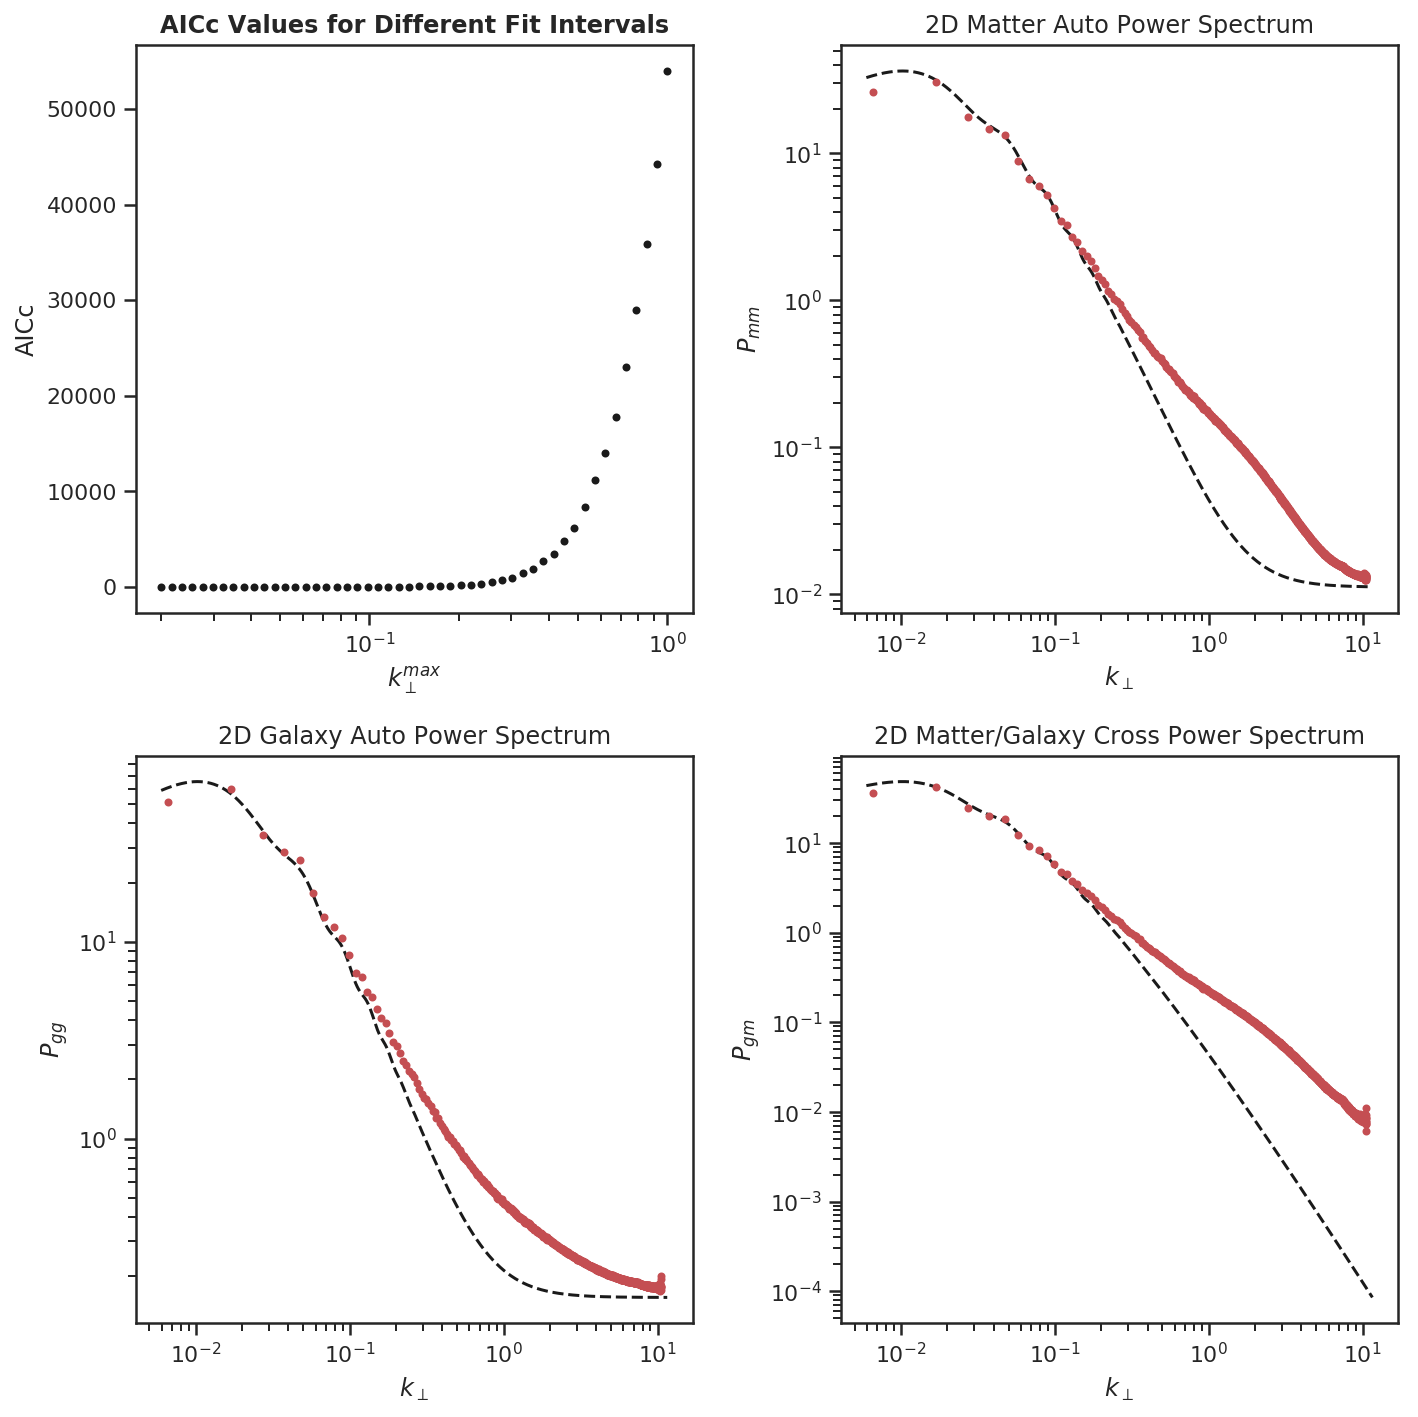

In [10]:
min_aicc = model_1_arr[0]["AICc"]
min_aicc_ind = 0

for i, model in enumerate(model_1_arr):
    if model["AICc"] < min_aicc:
        min_aicc_ind = i
        min_aicc = model["AICc"]
        
#     if model["k_max"]< 0.2:
#         plt.plot(model["k_max"], model["AICc"], '.', color='k')
        

b_param = model_1_arr[min_aicc_ind]["b"]

k_thr = np.logspace(np.log10(0.9*np.min(k)), np.log10(1.1*np.max(k)), 1000)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)

k_max_fit_arr = list(map(lambda d: d['k_max'], model_1_arr))
aicc_fit_arr = list(map(lambda d: d['AICc'], model_1_arr))

plt.plot(k_max_fit_arr, aicc_fit_arr, '.', color = "k")

plt.title("AICc Values for Different Fit Intervals", fontweight="bold")
plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel(r"AICc")

plt.xscale("log")

plt.subplot(2,2,2)

plt.plot(k_thr, model_1.p_mm_model(k_thr, is_linear=True), linestyle="--",
         color="k")
plt.plot(k, p_dm, '.', color="r")

plt.title("2D Matter Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{mm}$")

plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,3)

plt.plot(k_thr, model_1.p_gg_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gg, '.', color="r")

plt.title("2D Galaxy Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gg}$")

plt.xscale("log")
plt.yscale("log")


plt.subplot(2,2,4)

plt.plot(k_thr, model_1.p_gm_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gm, '.', color="r")

plt.title("2D Matter/Galaxy Cross Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gm}$")

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

#### **Fit and Define Two Parameter Linear Model:**

Study the two parameter bias models for $P_{mm}, P_{gg}$ and $P_{gm}$ defined as follows:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear/non-linear matter power spectrum function using CCL, where $k = \sqrt{k_\parallel^2+k_\perp^2}$
2. Integrate over a range of values for $k_\parallel$ using the integral defined below to compute a theoretical estimate for the 2D galaxy auto power spectrum and galaxy/matter cross power spectrum using the following models.
    * **Two Parameter Model Definitions:**
$$P_{mm}(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n_{dm}}}, \ \ \ P_{gg}(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}(b_1+b_1'k^2)^2P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n_g}}, \ \ \ P_{gm}(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}(b_1+b_1'k^2)P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel$$


**Shot-Noise:** Contribution modeled by $\frac{1}{\overline{n_{dm}}}$ and $\frac{1}{\overline{n_{g}}}$, where $\overline{n_{dm}}$ and $\overline{n_{g}}$ are the average dark matter particle and average galaxy number density, respectively.

In [11]:
def p_mm_model(k_perp, is_linear):
    
    """
    Computes the theoretical 2d matter auto power spectrum linear/non-linear 
    model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_mm_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """
        
    def integrand_func(k_par, k_perp):
        """
        Function to be integrated over in the two parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    p_mm_vals = 1/(np.pi)*integrator(k_perp)+1/N_BAR_DM

    return p_mm_vals
    

def p_gg_model(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy auto power spectrum with two
    parameter linear/non-linear model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): two element list containing the bias parameters of the model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_gg_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):
        """
        Function to be integrated over in the two parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return (b[0]+b[1]*k**2)**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)            

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_gg_vals = 1/(np.pi)*integrator(k_perp)+1/N_BAR_G

    return p_gg_vals
    
    
def p_gm_model(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy/matter cross power spectrum with two parameter
    linear/non-linear model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (float list): two element list containing the bias parameters of the model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_gm_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):
        """
        Function to be integrated over in the one parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return (b[0]+b[1]*k**2)*P_k*np.exp(-(k_par*SIGMA_CHI)**2)            

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_gm_vals = 1/(np.pi)*integrator(k_perp)   
    
    return p_gm_vals

model_2 = POW_SPEC_MODEL(p_mm_model, p_gg_model, p_gm_model, nparams=2)

In [12]:
#-------------------------------------FIT MODEL 2-------------------------------------#
print("FITTING TWO PARAMETER MODEL:")

# Fit over a specified k interval
k_min_fit = 0.0
k_max_arr = np.linspace(0.02, 1.0, 50)
k_max_arr = np.logspace(np.log10(0.02), np.log10(1.0), 50)

model_2_arr = np.empty(len(k_max_arr), dtype=dict)

# Fit upto various k
for ind, k_max_fit in enumerate(k_max_arr):
    
    progress_bar(ind, len(k_max_arr))
    
    # Select subset of data to apply fit
    fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
    
    k_fit = k[fit_indices]
    p_gg_fit = p_gg[fit_indices]
    p_gm_fit = p_gm[fit_indices]
    n_modes_fit = n_modes_g[fit_indices]

    b_guess = [1.7, 1.8]

    res = scipy.optimize.minimize(model_2.neg_log_like_total, b_guess, method='Nelder-Mead',
                                  args=(k_fit, p_gg_fit, p_gm_fit, n_modes_fit))
    
    # Compute AIC of this model
    log_L = -(model_2.neg_log_like_total(res.x, k_fit, p_gg_fit, p_gm_fit, 
                                         n_modes_fit))
    
    AICc = 2*1-2*log_L+(2*model_2.nparams**2+2*model_2.nparams)/(model_2.nparams-len(k_fit)-1)

    # Store model info in dictionary
    model_2_arr[ind] = {
        "k_min": k_min_fit,
        "k_max": k_max_fit,
        "n_data": len(k_fit),
        "b": res.x,
        "AICc": AICc,
    }
    
    progress_bar(ind+1, len(k_max_arr))

FITTING TWO PARAMETER MODEL:
Progress: [------------------->] 100%

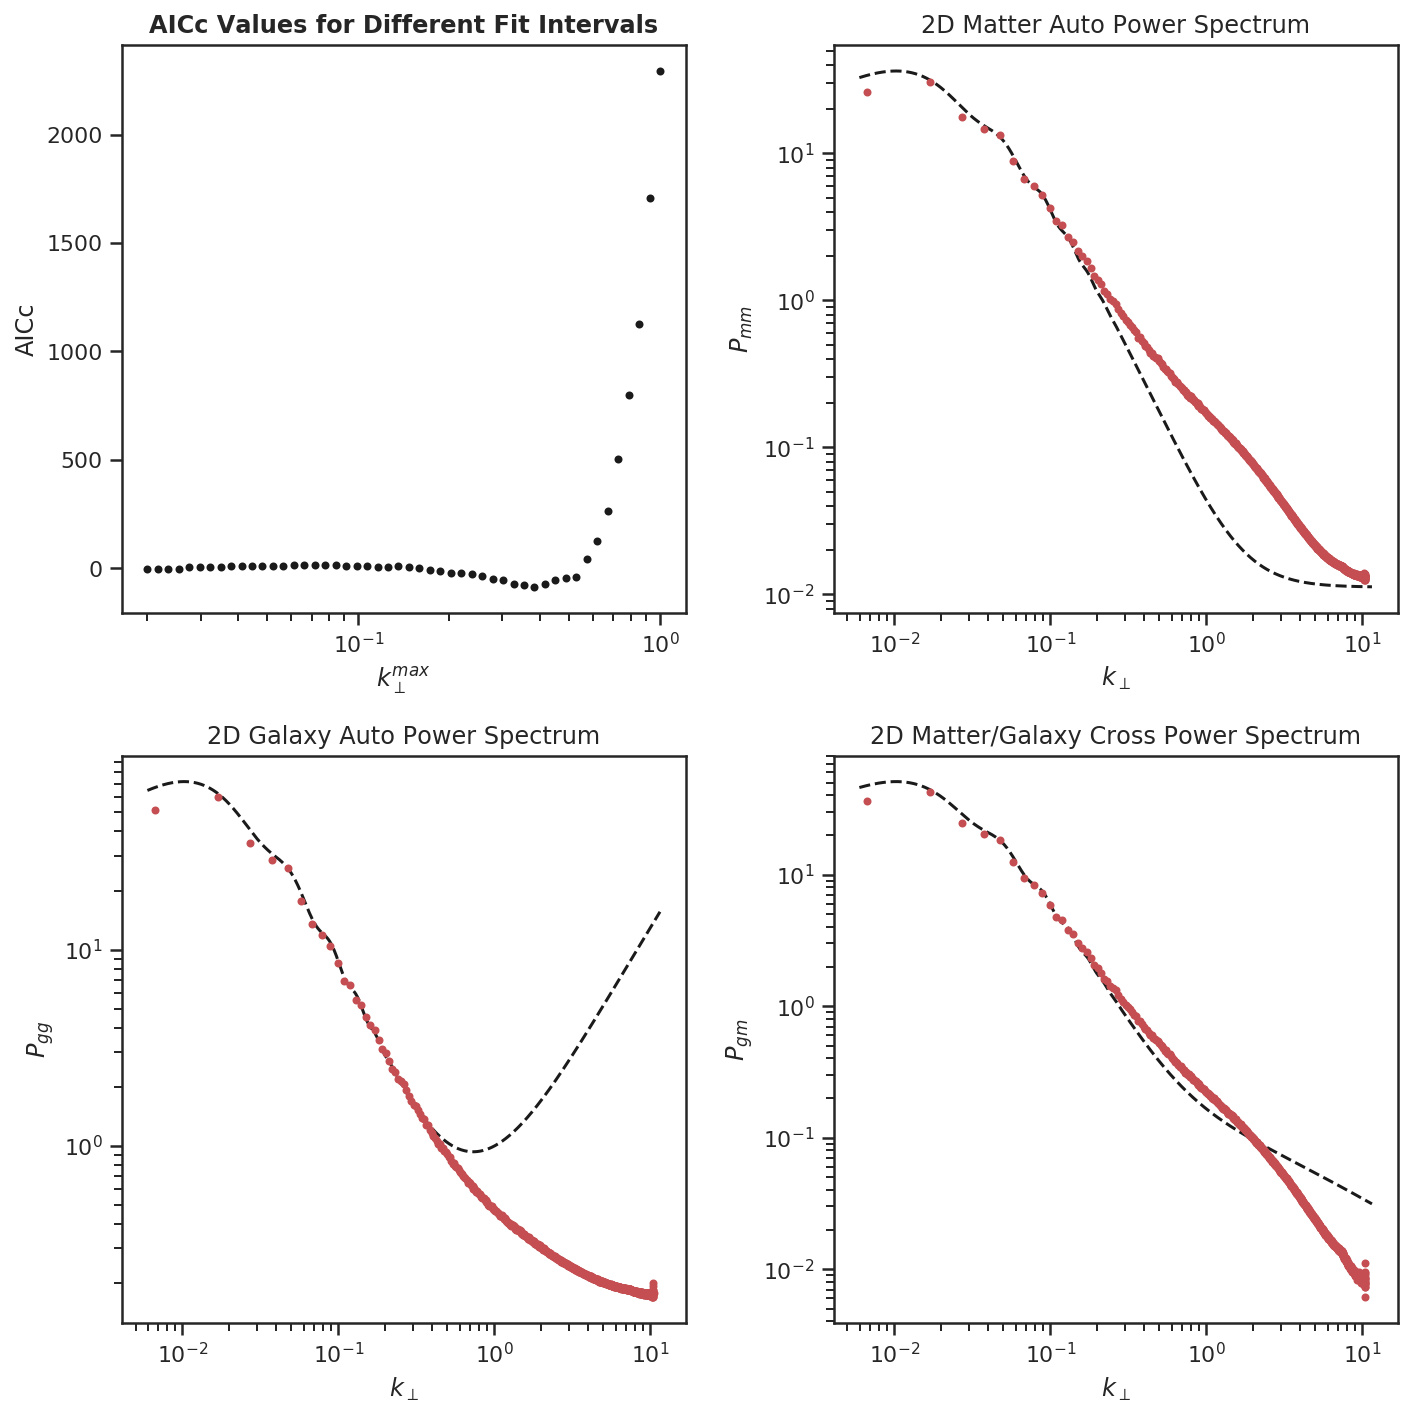

In [13]:
k_max_min_aicc = 0
min_aicc = model_2_arr[0]["AICc"]
min_aicc_ind = 0

for i, model in enumerate(model_2_arr):
    if model["AICc"] < min_aicc:
        min_aicc_ind = i
        min_aicc = model["AICc"]
        k_max_min_aicc = model["k_max"]

b_param = model_2_arr[min_aicc_ind]["b"]

k_thr = np.logspace(np.log10(0.9*np.min(k)), np.log10(1.1*np.max(k)), 1000)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)

k_max_fit_arr = list(map(lambda d: d['k_max'], model_2_arr))
aicc_fit_arr = list(map(lambda d: d['AICc'], model_2_arr))

plt.plot(k_max_fit_arr, aicc_fit_arr, '.', color = "k")

plt.title("AICc Values for Different Fit Intervals", fontweight="bold")
plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel(r"AICc")

plt.xscale("log")


plt.subplot(2,2,2)

plt.plot(k_thr, model_2.p_mm_model(k_thr, is_linear=True), linestyle="--",
         color="k")
plt.plot(k, p_dm, '.', color="r")

plt.title("2D Matter Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{mm}$")

plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,3)

plt.plot(k_thr, model_2.p_gg_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gg, '.', color="r")

plt.title("2D Galaxy Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gg}$")

plt.xscale("log")
plt.yscale("log")


plt.subplot(2,2,4)

plt.plot(k_thr, model_2.p_gm_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gm, '.', color="r")

plt.title("2D Matter/Galaxy Cross Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gm}$")

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

#### **Apply Corrections Using FastPT:**
Use FastPT to compute the corrections to the power spectrum and construct appropriate interpolators for each correction term. Models are of the following form:

$$P_{gg}^{sub} = (b_1^ 2(P_k+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) - 2(sig4_k)) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2 - \frac{4}{3}(sig4_k)) + \frac{1}{4}b_s^2 (Ps_2s_2) - \frac{8}{9}(sig4_k))+\frac{1}{\overline{N}}$$

$$P_{gg} = (b_1^ 2(P_k+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2)+ \frac{1}{4}b_s^2 (Ps_2s_2)+\frac{1}{\overline{N}}$$


$$P_{mg} = b_1 (P_k+oneloopkz) + \frac{1}{2}b_2(Pd_1d_2) +\frac{1}{2}b_s(Pd_1s_2)$$

In [14]:
# Compute the linear mps for perpendicular wave numbers
k_thr = np.logspace(np.log10(0.9*np.min(k)), np.log10(1.1*np.max(k)), 1000) # Array of wave numbers for FastPT calculation
k_interp = np.logspace(np.log10(0.9*np.min(k_thr)), np.log10(1.1*np.max(k_thr)), 10000) # Array of wavenumbers for FastPt correction intepolators
P_lin = pyccl.linear_matter_power(COSMO_CCL, k_interp, COSMO.scale_factor(Z_RED_SHIFT))
Growth = 1

# Setup Fourier Coefficient Window and padding
C_window=.75
P_window=None
n_pad=int(0.5*len(k_interp))
to_do=['dd_bias']

# Initialize the FASTPT class
fastpt=FASTPT(k_interp,to_do=to_do, n_pad=n_pad)

# Compute one loop bias
bias_fpt = fastpt.one_loop_dd_bias(P_lin, P_window=P_window, C_window=C_window)

# Compute correction terms and construct appropriate interpolators
one_loopkz = Growth**4 * bias_fpt[0]
Pd1d2 = Growth**4 * bias_fpt[2]
Pd2d2 = Growth**4 * bias_fpt[3]
Pd1s2 = Growth**4 * bias_fpt[4]
Pd2s2 = Growth**4 * bias_fpt[5]
Ps2s2 = Growth**4 * bias_fpt[6]
sig4kz = Growth**4 * bias_fpt[7] * np.ones_like(bias_fpt[0])

# Construct interpolators for 3D correction factors
P_lin_interp = scipy.interpolate.interp1d(k_interp, P_lin) 
one_loop_interp = scipy.interpolate.interp1d(k_interp, one_loopkz)
Pd1d2_interp = scipy.interpolate.interp1d(k_interp, Pd1d2)
Pd2d2_interp = scipy.interpolate.interp1d(k_interp, Pd2d2)
Pd1s2_interp = scipy.interpolate.interp1d(k_interp, Pd1s2)
Pd2s2_interp = scipy.interpolate.interp1d(k_interp, Pd2s2)
Ps2s2_interp = scipy.interpolate.interp1d(k_interp, Ps2s2)
sig4kz_interp = scipy.interpolate.interp1d(k_interp, sig4kz)
    
    
def get_pow_2d_correction(k_perp_arr, interp):
    """
    Computes the 2d power spectrum corrections for an associated interpolator
    
    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    interp (scipy interp1d): interpolator that has the associated correction factors
    for a range of wavenumbers

    Returns:
    correction (float array): array containing the integrated correction term weighted with
    Gaussian kernel
    
    """
    
    def integrand_func(k_par, k_perp):
        """
        Interpolator values to be summed over perpendicular wave numbers weighted with Gaussian kernel
        """
        k = np.sqrt(k_perp**2+k_par**2)
        
        return interp(k)*np.exp(-(k_par*SIGMA_CHI)**2)  

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    correction = 1/(np.pi)*integrator(k_perp_arr)
    
    return correction 

Initializing k-grid quantities...


#### **Fit Bias Parameters:**
Fit $b_1$ and $b_2$ bias parameters simultaneously.

$$P_{gg}^{sub} = b_1^ 2(P_k^{lin}+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) - 2(sig4_k)) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2 - \frac{4}{3}(sig4_k)) + \frac{1}{4}b_s^2 (Ps_2s_2) - \frac{8}{9}(sig4_k))+\frac{1}{\overline{N}}$$

$$P_{gg} = b_1^ 2(P_k^{lin}+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2(Pd_2d_2) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2)+ \frac{1}{4}b_s^2 (Ps_2s_2)+\frac{1}{\overline{N}}$$


$$P_{mg} = b_1 (P_k^{lin}+oneloopkz) + \frac{1}{2}b_2(Pd_1d_2) +\frac{1}{2}b_s(Pd_1s_2)$$

In [16]:
def p_mm_model(k_perp, is_linear):
    
    """
    Computes the theoretical 2d matter auto power spectrum linear/non-linear 
    model as defined in above cell

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)
    
    Returns:
    p_mm_vals (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """
        
    def integrand_func(k_par, k_perp):
        """
        Function to be integrated over in the two parameter model
        """

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
        
        return P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    p_mm_vals = 1/(np.pi)*integrator(k_perp)+1/N_BAR_DM

    return p_mm_vals


def p_gg_model(k, b, is_linear=True):
    """
    Function to define the galaxy auto power spectrum model you wish to fit using FastPT corrections
    
    Input: 
    b (float array): an array containing all of the bias parameters for the model
    
    Returns:
    Float array of computed values of pgg based on input model
    """
    b1 = b[0]
    b2 = b[1]
    bs = (-4./7)*(b1-1)
    
    n = len(k) # Determines how many of the power spectra values are fit up to
    
    model = b1**2*(p_lin(k)+p_one_loop(k))+b1*b2*Pd1d2(k)+1/4*b2**2*Pd2d2(k)+b1*bs*(Pd1s2(k))+1/2*b2*bs*Pd2s2(k)+1/4*bs**2*Ps2s2(k)+1/N_BAR_G
    
    return model


def p_gm_model(k, b, is_linear=True):
    """
    Function to define the galaxy/matter cross power spectrum model you wish to fit using FastPT corrections
   
    Input: 
    b (float array): an array containing all of the bias parameters for the model
    
    Returns:
    Float array of computed values of pgm based on input model
    """
    
    b1 = b[0]
    b2 = b[1]
    bs = (-4./7)*(b1-1)
    
    n = len(k) # Determines how many of the power spectra values are fit up to
    
    return b1*(p_lin(k)+p_one_loop(k))+1/2*b2*Pd1d2(k)+1/2*bs*Pd1s2(k)

model_3 = POW_SPEC_MODEL(p_mm_model, p_gg_model, p_gm_model, nparams=2)

In [17]:
print("Computing Fast PT Corrections")
# Computes the fast pt corrections and linear matter power spectra at the wavenumbers corresponding
# to measured power spectrum entries

# Extract 2D correction factors by integrating using previously defined 3D interpolators
k_interp_old = k_interp
k_interp = k_thr
p_mm_thr =  model_3.p_mm_model(k_interp, is_linear=True)-1/N_BAR_DM  # 2D linear matter power spectrum without any shot-noise

p_lin = scipy.interpolate.interp1d(k_interp, p_mm_thr)                                
p_one_loop = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, one_loop_interp))
Pd1d2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Pd1d2_interp))
Pd1d2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Pd1d2_interp))
Pd2d2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Pd2d2_interp))
Pd1s2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Pd1s2_interp))
Pd2s2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Pd2s2_interp))
Ps2s2 = scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, Ps2s2_interp))
sigk4kz=scipy.interpolate.interp1d(k_interp, get_pow_2d_correction(k_interp, sig4kz_interp))

k_interp = k_interp_old
print("Fast PT Analysis Complete")

Computing Fast PT Corrections
Fast PT Analysis Complete


In [19]:
#-------------------------------------FIT AND CONSTRUCT MODEL 3-------------------------------------#
print("FITTING FAST-PT PARAMETER MODEL:")

# Fit over a specified k interval
k_min_fit = 0.0
k_max_arr = np.linspace(0.02, 1.0, 50)
k_max_arr = np.logspace(np.log10(0.02), np.log10(1.0), 50)

model_3_arr = np.empty(len(k_max_arr), dtype=dict)

# Fit upto various k
for ind, k_max_fit in enumerate(k_max_arr):
    progress_bar(ind, len(k_max_arr))
    
    is_linear = True
    
    # Select subset of data to apply fit
    fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
    
    k_fit = k[fit_indices]
    p_gg_fit = p_gg[fit_indices]
    p_gm_fit = p_gm[fit_indices]
    n_modes_fit = n_modes_g[fit_indices]


    b_guess = [1.7, 1.8]
    
    res = scipy.optimize.minimize(model_3.neg_log_like_total, b_guess, method='Nelder-Mead',
                                  args=(k_fit, p_gg_fit, p_gm_fit, n_modes_fit))
    
    # Compute AIC of this model
    log_L = -(model_3.neg_log_like_total(res.x, k_fit, p_gg_fit, p_gm_fit, 
                                         n_modes_fit))
    AICc = 2*1-2*log_L+(2*model_3.nparams**2+2*model_3.nparams)/(model_3.nparams-len(k_fit)-1)

    # Store model info in dictionary
    model_3_arr[ind] = {
        "k_min": k_min_fit,
        "k_max": k_max_fit,
        "n_data": len(k_fit),
        "b": res.x,
        "AICc": AICc,
    }
    
    progress_bar(ind+1, len(k_max_arr))

FITTING FAST-PT PARAMETER MODEL:
Progress: [------------------->] 100%

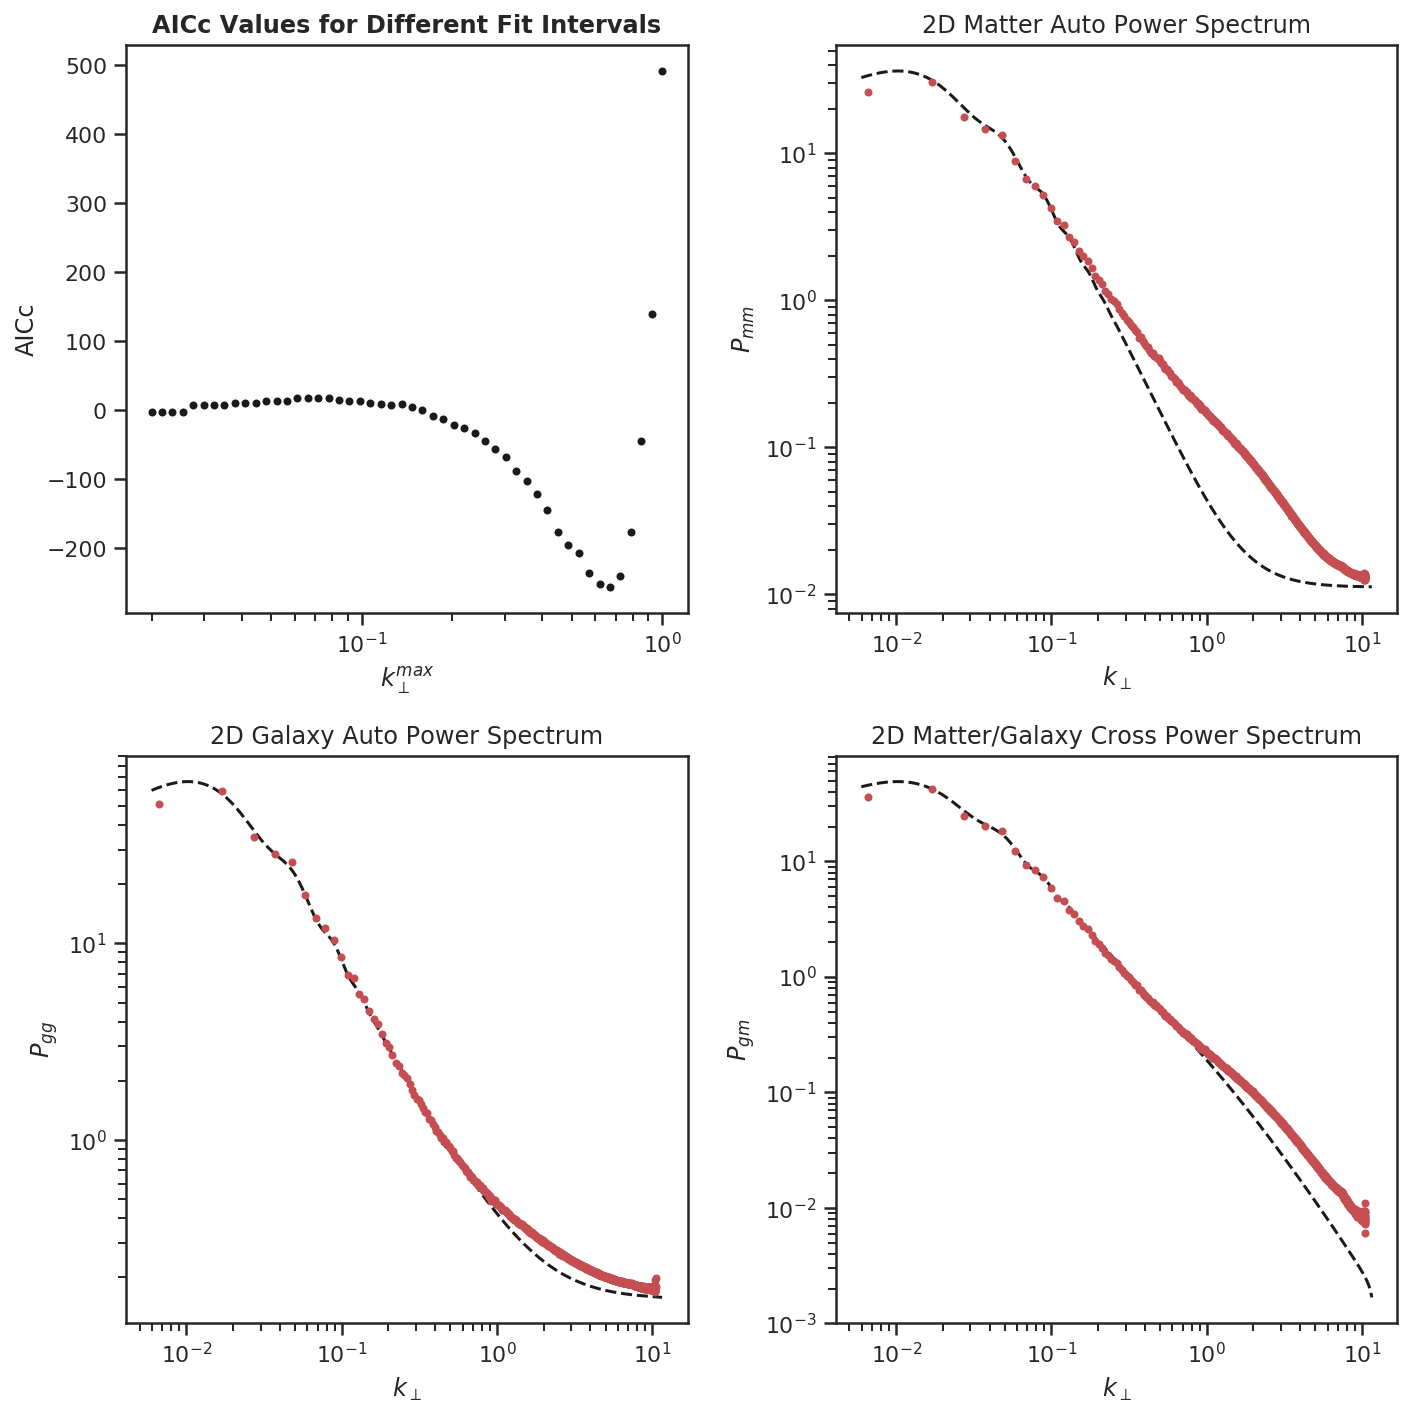

In [20]:
k_max_min_aicc = 0
min_aicc = model_3_arr[0]["AICc"]
min_aicc_ind = 0

for i, model in enumerate(model_3_arr):
    if model["AICc"] < min_aicc:
        min_aicc_ind = i
        min_aicc = model["AICc"]
        k_max_min_aicc = model["k_max"]

b_param = model_3_arr[min_aicc_ind]["b"]

k_thr = np.logspace(np.log10(0.9*np.min(k)), np.log10(1.1*np.max(k)), 1000)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)

k_max_fit_arr = list(map(lambda d: d['k_max'], model_3_arr))
aicc_fit_arr = list(map(lambda d: d['AICc'], model_3_arr))

plt.plot(k_max_fit_arr, aicc_fit_arr, '.', color = "k")

plt.title("AICc Values for Different Fit Intervals", fontweight="bold")
plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel(r"AICc")

plt.xscale("log")


plt.subplot(2,2,2)

plt.plot(k_thr, model_3.p_mm_model(k_thr, is_linear=True), linestyle="--",
         color="k")
plt.plot(k, p_dm, '.', color="r")

plt.title("2D Matter Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{mm}$")

plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,3)

plt.plot(k_thr, model_3.p_gg_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gg, '.', color="r")

plt.title("2D Galaxy Auto Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gg}$")

plt.xscale("log")
plt.yscale("log")


plt.subplot(2,2,4)

plt.plot(k_thr, model_3.p_gm_model(k_thr, b_param, is_linear=True), linestyle="--", 
         color="k")
plt.plot(k, p_gm, '.', color="r")

plt.title("2D Matter/Galaxy Cross Power Spectrum")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$P_{gm}$")

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

#### **Plot Final Power Spectra and Models and Compare Models:**

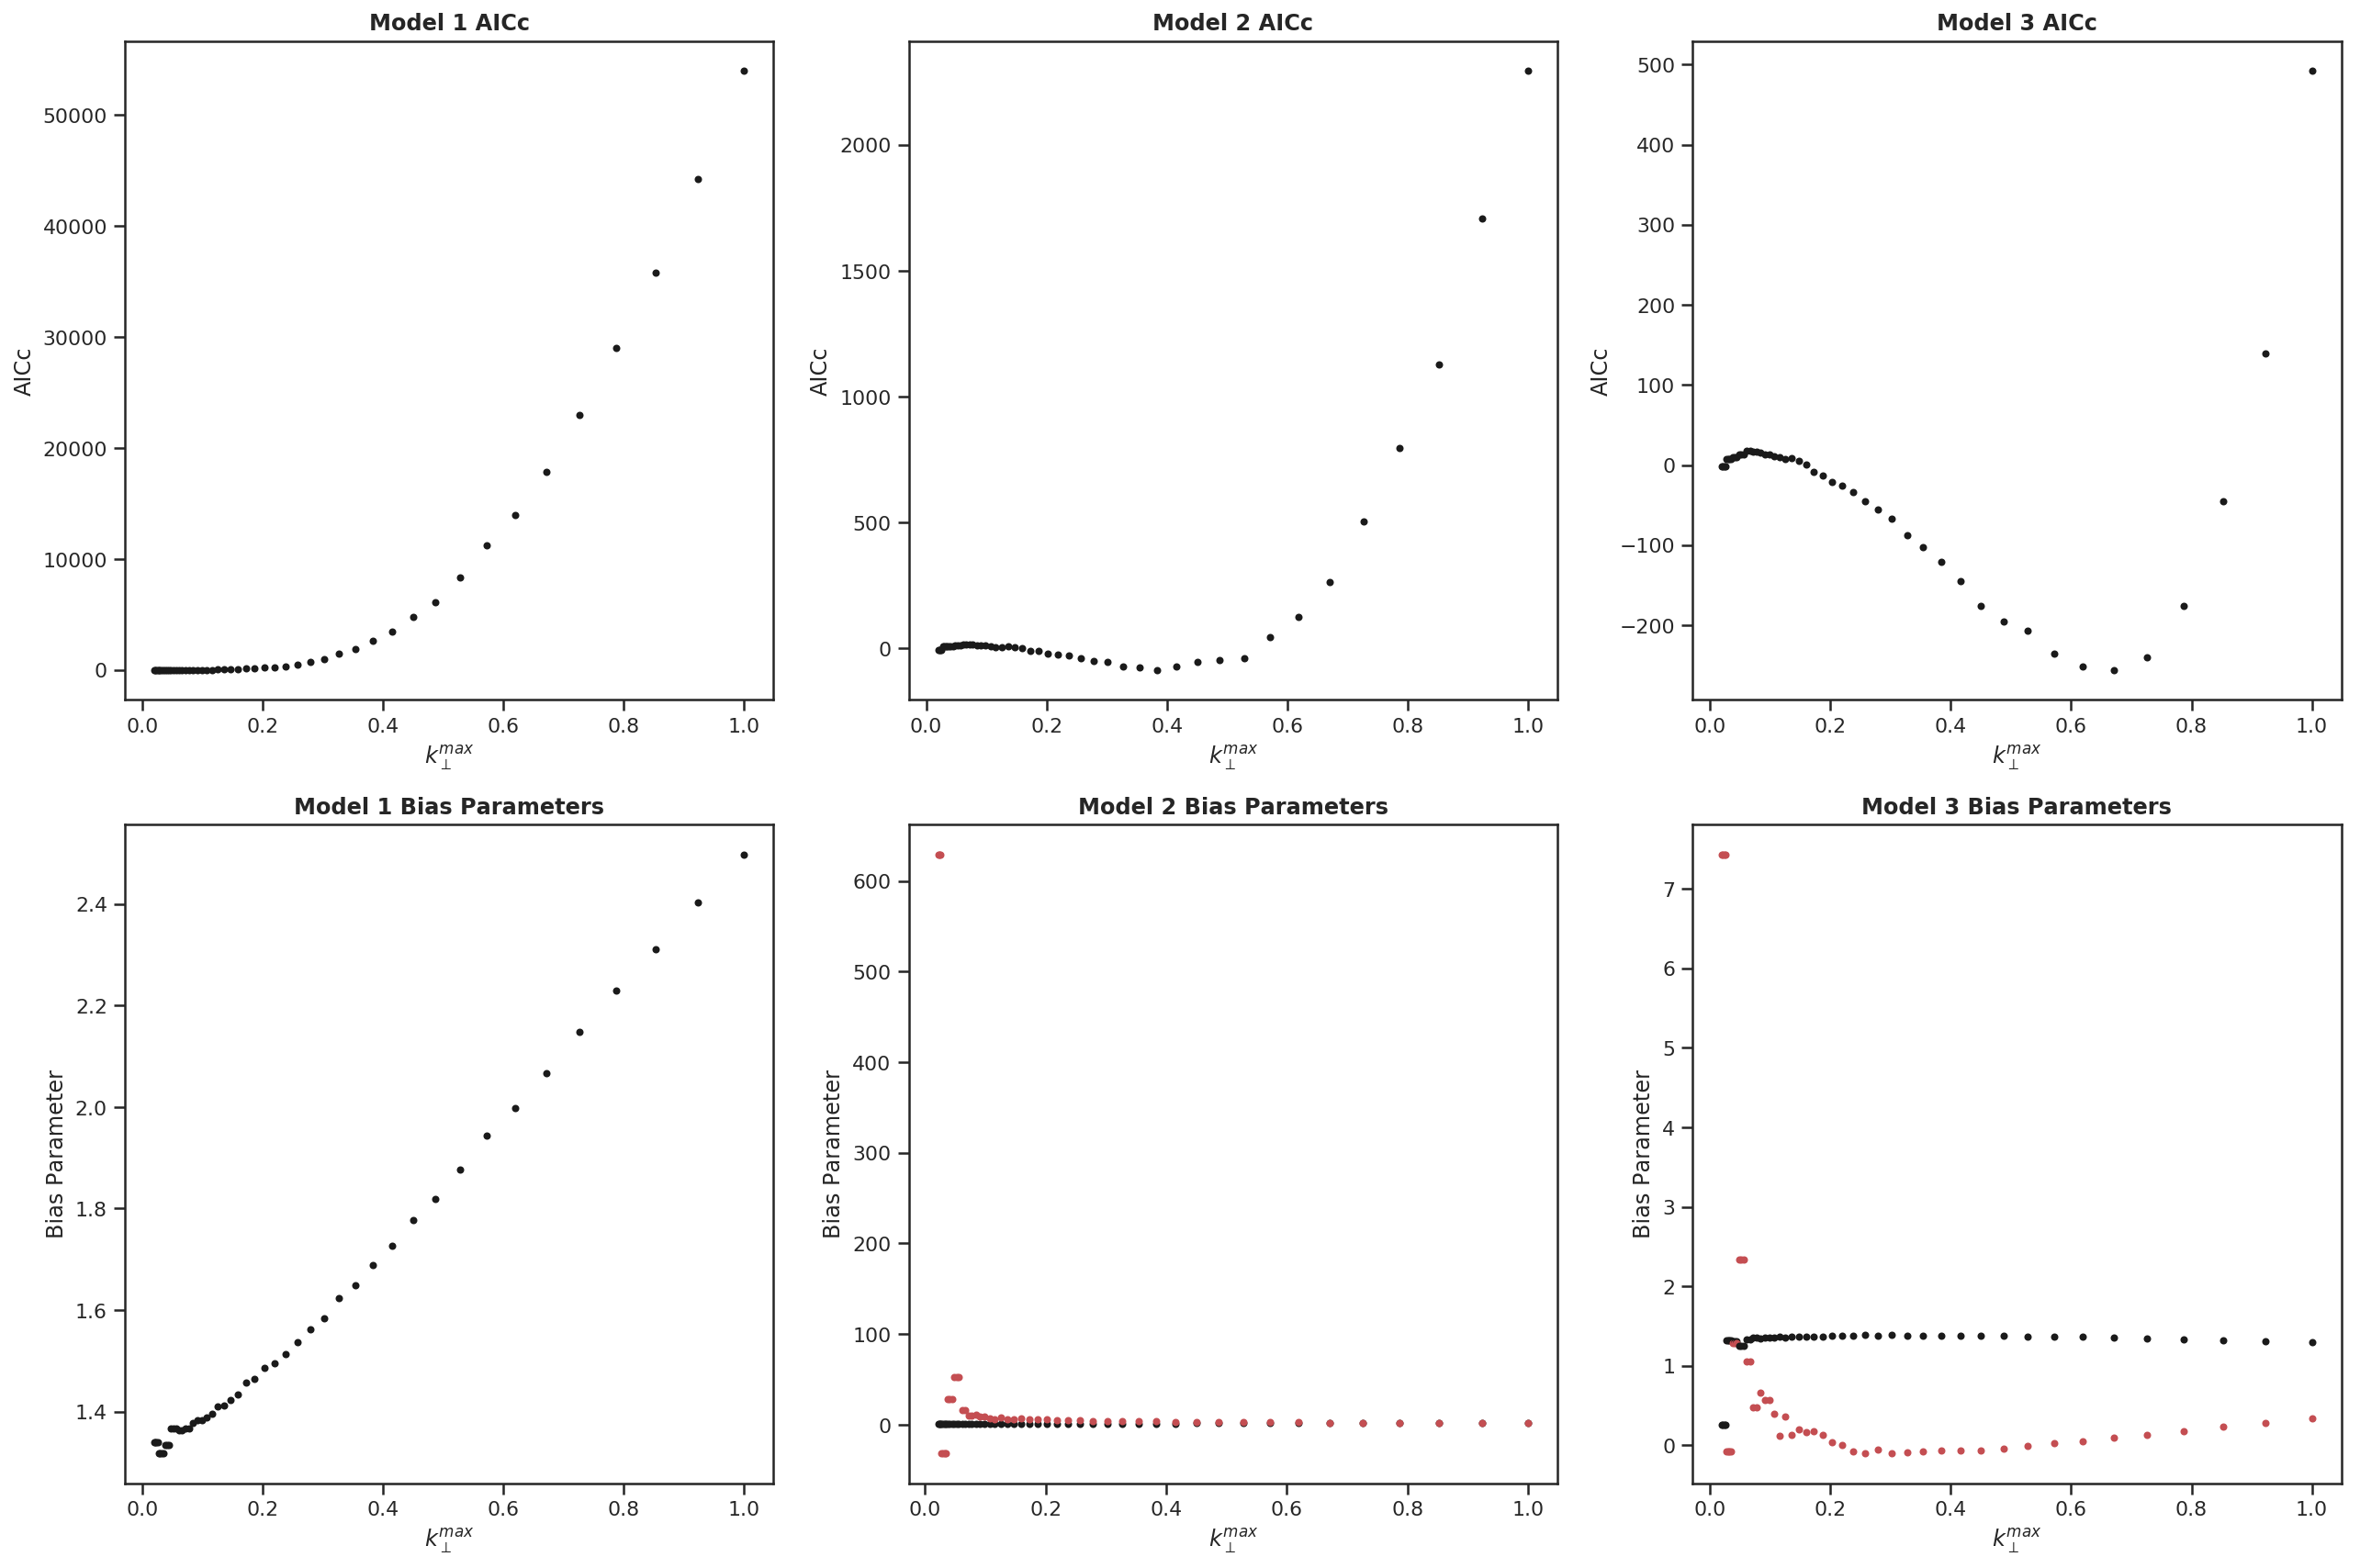

In [21]:
plt.figure(figsize=(18,12))

plt.subplot(2,3 ,1)

for model in model_1_arr:
    plt.plot(model["k_max"], model["AICc"], '.', color='k')

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("AICc")
plt.title("Model 1 AICc", fontweight="bold")
    
plt.subplot(2,3 ,2)

for model in model_2_arr:
    plt.plot(model["k_max"], model["AICc"], '.', color='k')

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("AICc")
plt.title("Model 2 AICc", fontweight="bold")

plt.subplot(2,3 ,3)

for model in model_3_arr:
    plt.plot(model["k_max"], model["AICc"], '.', color='k')

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("AICc")
plt.title("Model 3 AICc", fontweight="bold")

plt.subplot(2,3 ,4)
for model in model_1_arr:
    plt.plot(model["k_max"], model["b"][0], '.', color='k')

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("Bias Parameter")
plt.title("Model 1 Bias Parameters", fontweight="bold")


plt.subplot(2,3 ,5)

for i, model in enumerate(model_2_arr):
    if i > 0:
        plt.plot(model["k_max"], model["b"][0], '.', color='k')
        plt.plot(model["k_max"], model["b"][1], '.', color='r')

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("Bias Parameter")
plt.title("Model 2 Bias Parameters", fontweight="bold")

plt.subplot(2,3 ,6)

for i, model in enumerate(model_3_arr):
    plt.plot(model["k_max"], model["b"][0], '.', color='k')
    plt.plot(model["k_max"], model["b"][1], '.', color='r')
    

plt.xlabel(r"$k_\perp^{max}$")
plt.ylabel("Bias Parameter")
plt.title("Model 3 Bias Parameters", fontweight="bold")

plt.savefig("AICc_and_bias_param.png", dpi=250)
plt.tight_layout()

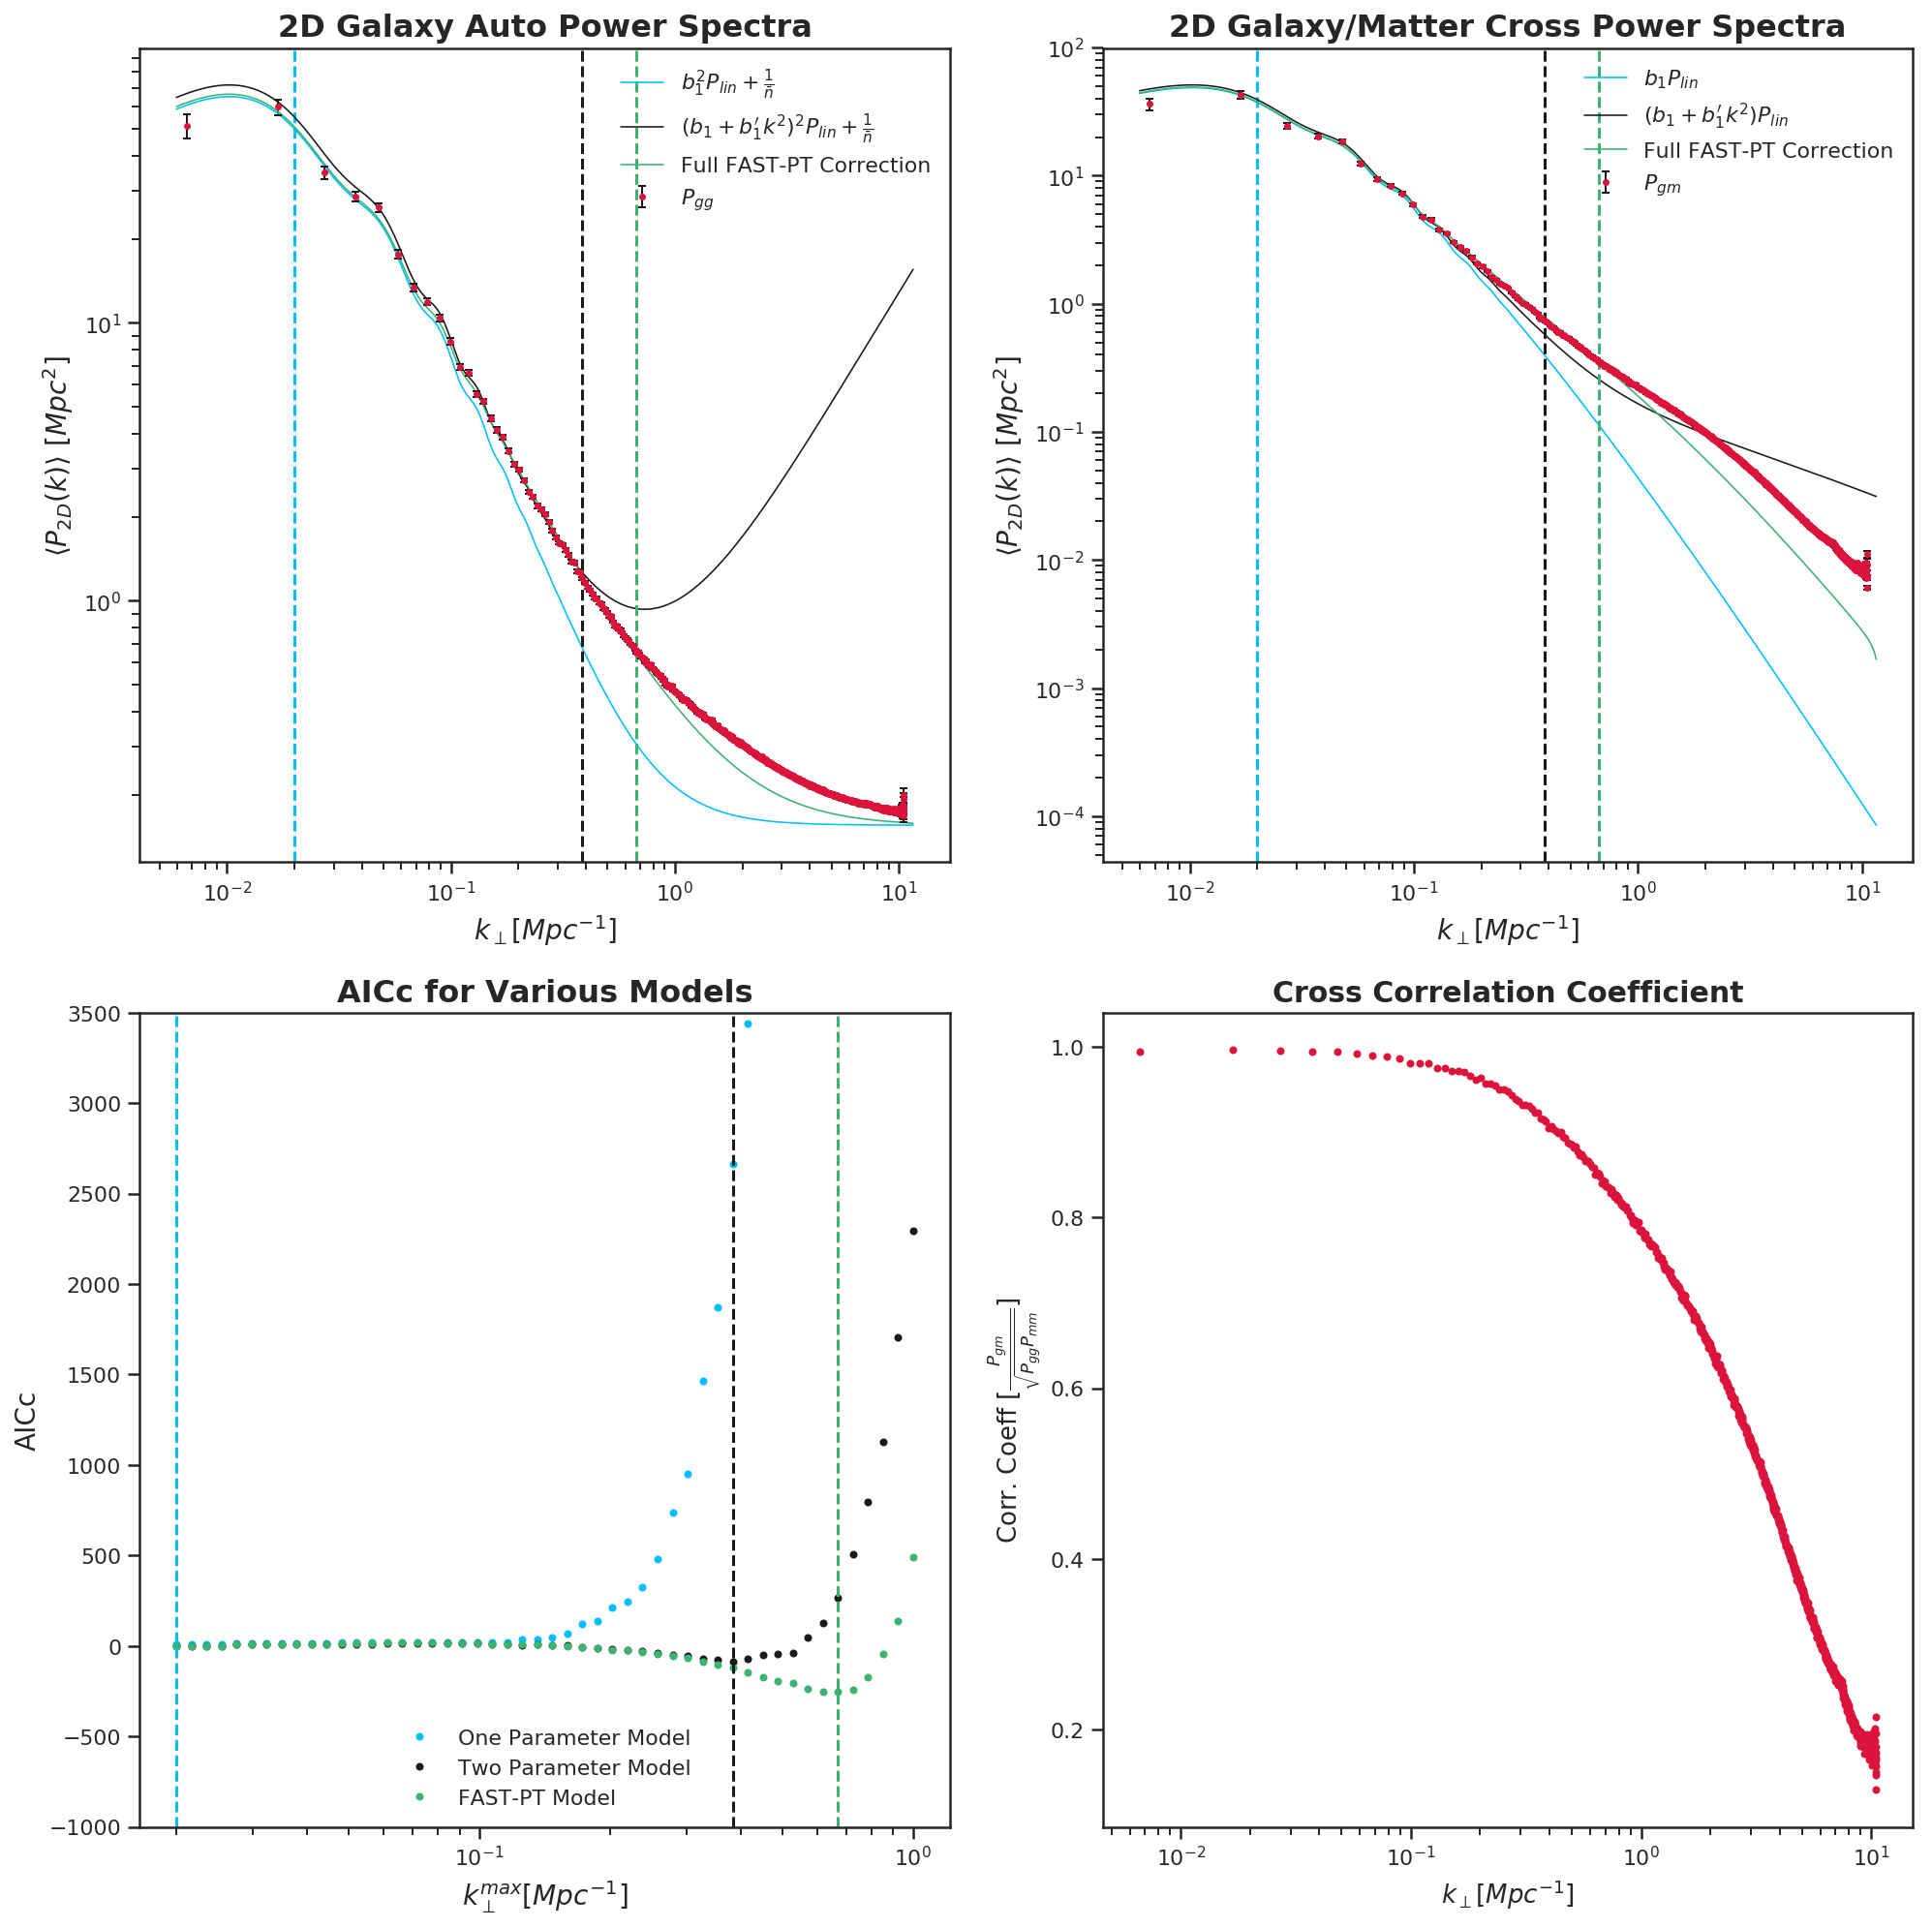

In [24]:
plt.figure(figsize=(14,14))

model_1_best_fit_ind = np.argmin(list(map(lambda d: d['AICc'], model_1_arr)))
model_2_best_fit_ind = np.argmin(list(map(lambda d: d['AICc'], model_2_arr)))
model_3_best_fit_ind = np.argmin(list(map(lambda d: d['AICc'], model_3_arr)))


#-----------------------Plot Galaxy Auto Power Spectra--------------------------
plt.subplot(2,2,1)

plt.plot(k_thr, model_1.p_gg_model(k_thr, model_1_arr[model_1_best_fit_ind]["b"], True), 
         label=r"$b_1^2P_{lin}+\frac{1}{\bar{n}}$", linestyle="-", color="deepskyblue",
         linewidth=0.8)
plt.axvline(model_1_arr[model_1_best_fit_ind]["k_max"], linestyle="--", color="deepskyblue")

plt.plot(k_thr,model_2.p_gg_model(k_thr, model_2_arr[model_2_best_fit_ind]["b"], True), 
         label=r"$(b_1+b_1'k^2)^2P_{lin}+\frac{1}{\bar{n}}$", linestyle="-", color="k",
         linewidth=0.8)
plt.axvline(model_2_arr[model_2_best_fit_ind]["k_max"], linestyle="--", color="k")

plt.plot(k_thr, model_3.p_gg_model(k_thr, model_3_arr[model_3_best_fit_ind]["b"], True),  
         label=r"Full FAST-PT Correction", linestyle="-", color="mediumseagreen",
         linewidth=0.8)
plt.axvline(model_3_arr[model_3_best_fit_ind]["k_max"], linestyle="--", color="mediumseagreen")

plt.errorbar(k, p_gg, 
             yerr=np.sqrt(2*p_gg**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"$P_{gg}$")

# Format legend
plt.legend(frameon=False)

# Add Labels
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=14)
plt.title("2D Galaxy Auto Power Spectra", fontweight="bold", fontsize=16)
plt.xscale("log")
plt.yscale("log")

#-----------------------Plot Galaxy/Matter Cross Power Spectra--------------------------
plt.subplot(2,2,2)

plt.plot(k_thr, model_1.p_gm_model(k_thr, model_1_arr[model_1_best_fit_ind]["b"], True), 
         label=r"$b_1P_{lin}$", linestyle="-", color="deepskyblue",
         linewidth=0.8)
plt.axvline(model_1_arr[model_1_best_fit_ind]["k_max"], linestyle="--", color="deepskyblue")

plt.plot(k_thr,model_2.p_gm_model(k_thr, model_2_arr[model_2_best_fit_ind]["b"], True), 
         label=r"$(b_1+b_1'k^2)P_{lin}$", linestyle="-", color="k",
         linewidth=0.8)
plt.axvline(model_2_arr[model_2_best_fit_ind]["k_max"], linestyle="--", color="k")

plt.plot(k_thr, model_3.p_gm_model(k_thr, model_3_arr[model_3_best_fit_ind]["b"], True),  
         label=r"Full FAST-PT Correction", linestyle="-", color="mediumseagreen",
         linewidth=0.8)
plt.axvline(model_3_arr[model_3_best_fit_ind]["k_max"], linestyle="--", color="mediumseagreen")

plt.errorbar(k, p_gm, 
             yerr=np.sqrt(2*p_gm**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"$P_{gm}$")

# Format legend
plt.legend(frameon=False)

# Add Labels
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=14)
plt.title("2D Galaxy/Matter Cross Power Spectra", fontweight="bold", fontsize=16)
plt.xscale("log")
plt.yscale("log")

#----------------------Plot Galaxy/Matter Cross Power Spectra----------------------
plt.subplot(2,2,3)

model_k_max = list(map(lambda d: d['k_max'], model_1_arr))
model_1_aicc = list(map(lambda d: d['AICc'], model_1_arr))
model_2_aicc = list(map(lambda d: d['AICc'], model_2_arr))
model_3_aicc = list(map(lambda d: d['AICc'], model_3_arr))

# plt.plot(k, np.ones(len(k)), color="white") # Make scale same as power spectra plots
plt.plot(model_k_max, model_1_aicc, marker='.', linestyle="none",
         color="deepskyblue", label="One Parameter Model")
plt.plot(model_k_max, model_2_aicc, marker='.', linestyle="none",
         color="k", label="Two Parameter Model")
plt.plot(model_k_max, model_3_aicc, marker='.', linestyle="none",
         color="mediumseagreen", label="FAST-PT Model")

plt.axvline(model_1_arr[model_1_best_fit_ind]["k_max"], linestyle="--", color="deepskyblue")
plt.axvline(model_2_arr[model_2_best_fit_ind]["k_max"], linestyle="--", color="k")
plt.axvline(model_3_arr[model_3_best_fit_ind]["k_max"], linestyle="--", color="mediumseagreen")

plt.ylim(-1000, 3500)
plt.xscale("log")

# Format legend
plt.legend(frameon=False)


plt.xlabel(r"$k_\perp^{max} [Mpc^{-1}]$", fontsize=14)
plt.ylabel("AICc", fontsize=14)
plt.title("AICc for Various Models", fontweight="bold", fontsize=16)




#----------------------Plot Cross Correlation Coefficient----------------------
plt.subplot(2,2,4)

# Compute cross correlation coefficient
cross_corr_coef = p_gm/np.sqrt(p_gg*p_dm)

plt.plot(k, cross_corr_coef, '.', color = "crimson")

plt.xscale("log")
plt.title("Cross Correlation Coefficient", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=13)
plt.ylabel(r"Corr. Coeff [$\frac{P_{gm}}{\sqrt{P_{gg} P_{mm}}}$]", fontsize=13)

plt.tight_layout()

plt.savefig("model_comparision.png", dpi=250)